In [1]:
import jax
import chex
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

from io import StringIO
from functools import partial
from datetime import datetime

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 16

In [3]:
theta_values = -2, -1, 0, 3, 7,

## HMM Orstein-Uhlenbeck process

$$
    x_{t+\Delta}^\ell = \kappa(\theta_{t, \ell} - x_{t, \ell}) \Delta + \sigma\sqrt{\Delta} W_t
$$

with $W_t \sim \cal{N}(0, 1)$

In [4]:
transition_matrix = jnp.array([
    [0.00,  0.05, 0.05, 0.05, 0.05],
    [0.10,  00.0, 0.10, 0.05, 0.05],
    [0.10,  0.20, 0.00, 0.05, 0.05],
    [0.10,  0.20, 0.01, 0.00, 0.05],
    [0.10,  0.20, 0.20, 0.20, 0.00],
])

p_stay = 1 - transition_matrix.sum(axis=1)
transition_matrix = transition_matrix.at[jnp.diag_indices(5)].set(p_stay)

transition_matrix

Array([[0.8       , 0.05      , 0.05      , 0.05      , 0.05      ],
       [0.1       , 0.7       , 0.1       , 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.59999996, 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.01      , 0.64      , 0.05      ],
       [0.1       , 0.2       , 0.2       , 0.2       , 0.3       ]],      dtype=float32)

## Loading datset

In [5]:
url = """
https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=345427200&period2=1701993600&interval=1d&events=history&includeAdjustedClose=true
"""

In [6]:
date_init = datetime.timestamp(datetime(2000, 1, 1))
date_end = datetime.timestamp(datetime(2023, 12, 8))

config = {
    "events": "history",
    "period1": str(int(date_init)),
    "period2": str(int(date_end)),
    "includeAdjustedClose": "true"
}

In [7]:
assets = ["JPM", "AAPL", "SHEL", "WMT", "KO"]

In [8]:
datasets = {}
for asset in assets:
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{asset}"
    r = requests.get(
        url,
        headers={'User-agent': 'Mozilla/5.0'},
        params=config
    )

    data = pd.read_csv(StringIO(r.text))
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date")

    series = data["Adj Close"]
    series.name = asset
    datasets[asset] = series
datasets = pd.DataFrame.from_dict(datasets)

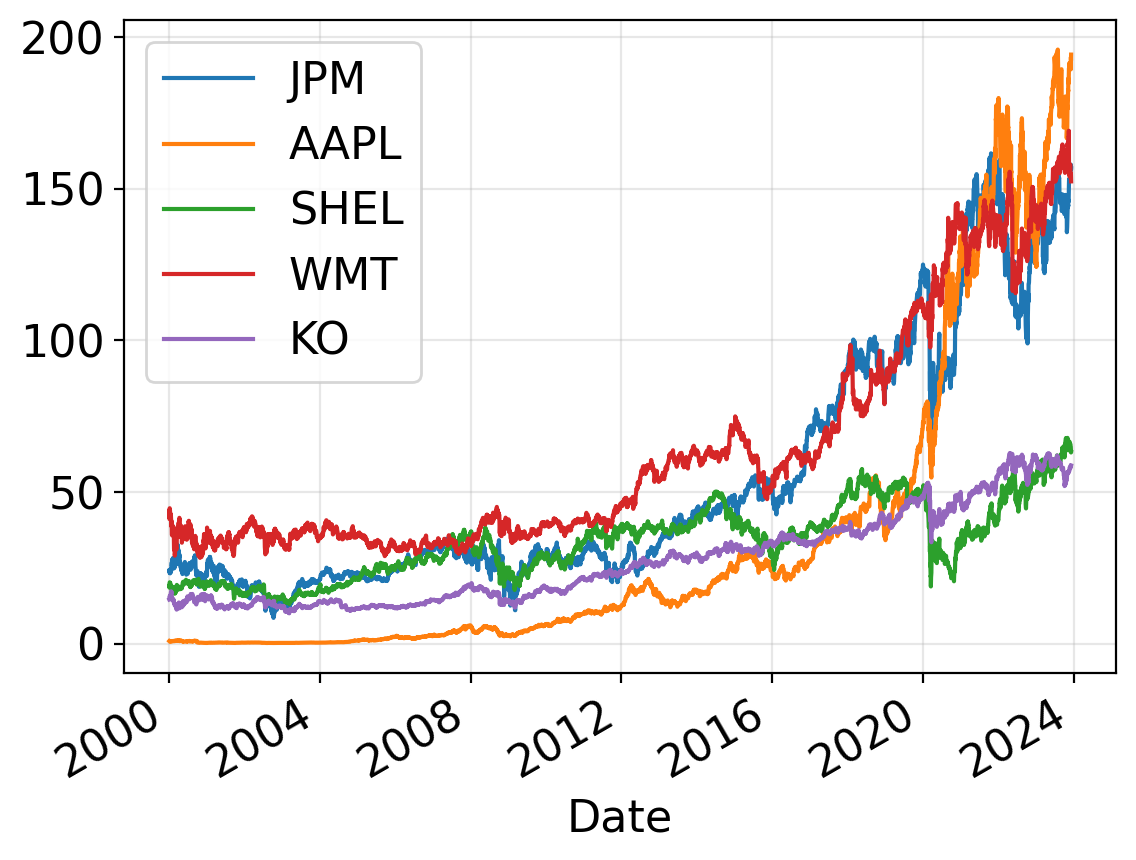

In [9]:
datasets.plot()
plt.grid(alpha=0.3)

In [10]:
returns = datasets.pct_change(5).dropna()
returns = jnp.array(returns.to_numpy())

$$
    \mathfrak{R}_T = P_T - P_T^*
$$

In [11]:
n_bandits = len(assets)
count_v = jnp.zeros(n_bandits)
value_v = jnp.zeros(n_bandits)

In [54]:
@chex.dataclass
class BanditState:
    count: jax.Array
    value: jax.Array
    key: jax.random.PRNGKey
    
    
@chex.dataclass
class BanditEWMState:
    value: jax.Array
    key: jax.random.PRNGKey

In [55]:
def epsilon_step(state, returns, epsilon):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]
    new_count = state.count[action] + 1
    new_value = state.value[action] + (reward - state.value[action]) / new_count
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        count=state.count.at[action].set(new_count),
        key=jax.random.split(state.key)[1]
    )
    return state, reward


def epsilon_ewm_step(state, returns, epsilon, alpha):
    key_choice, key_arm = jax.random.split(state.key)
    is_greedy = jax.random.bernoulli(key_choice, p=1 - epsilon)
    random_choice = jax.random.choice(key_arm, n_bandits)
    
    action = state.value.argmax() * is_greedy + random_choice * (1 - is_greedy) 
    reward = returns[action]

    new_value = state.value[action] + alpha * (reward - state.value[action])
    
    state = state.replace(
        value=state.value.at[action].set(new_value),
        key=jax.random.split(state.key)[1]
    )
    
    return state, reward

In [45]:
key = jax.random.PRNGKey(3141)

In [46]:
state = BanditState(count=count_v, value=value_v, key=key)

In [47]:
state_final, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=1e-6), state, returns)

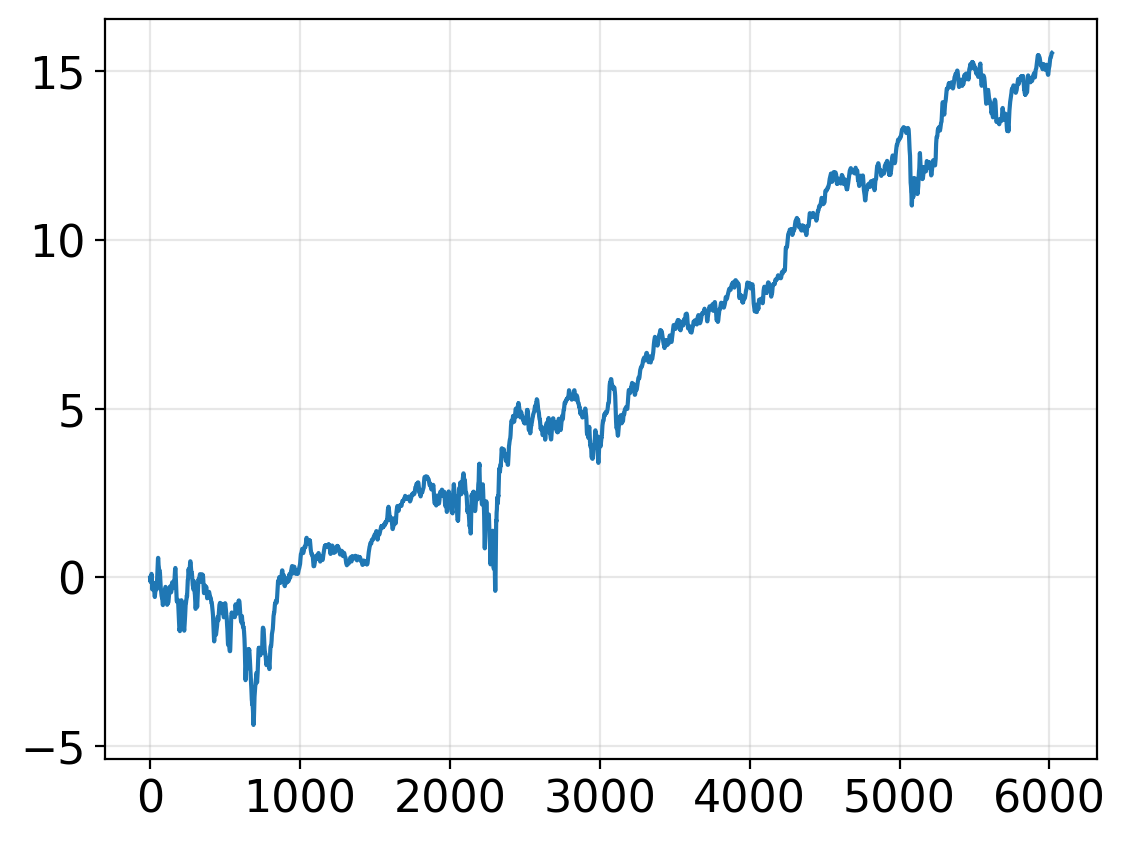

In [48]:
plt.plot(returns_bandit.cumsum())
plt.grid(alpha=0.3)

In [49]:
epsilon_values = jnp.linspace(1e-7, 1, 50)

In [50]:
@partial(jax.vmap, in_axes=(None, 0), out_axes=1)
def returns_bandit(state, epsilon):
    _, returns_bandit = jax.lax.scan(partial(epsilon_step, epsilon=epsilon), state, returns)
    return returns_bandit

In [51]:
epsilon_greedy_cumsum = np.array(returns_bandit(state, epsilon_values).cumsum(axis=0))

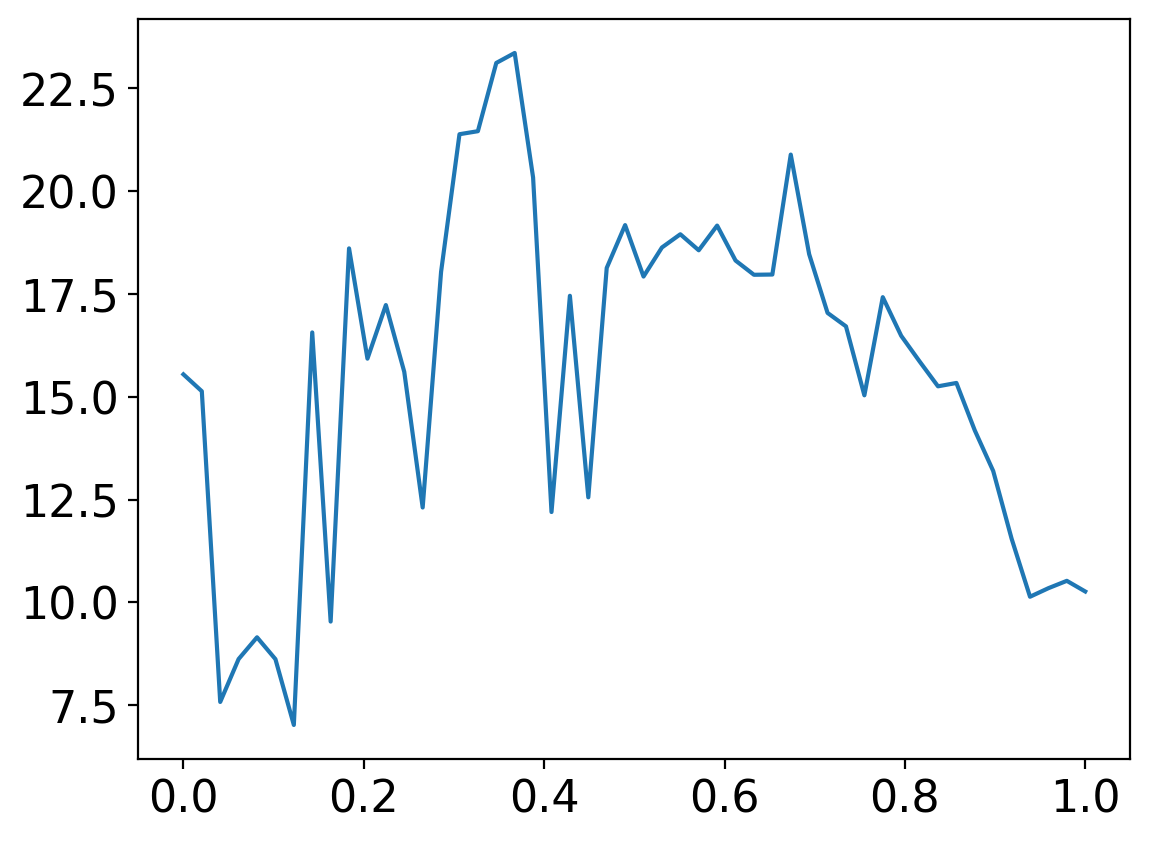

In [52]:
plt.plot(epsilon_values, epsilon_greedy_cumsum[-1])

## Non-stationary version

In [34]:
state = BanditEWMState(value=value_v, key=jax.random.PRNGKey(314))

In [35]:
state_final, returns_bandit = jax.lax.scan(partial(epsilon_ewm_step, epsilon=1e-6, alpha=0.9), state, returns)

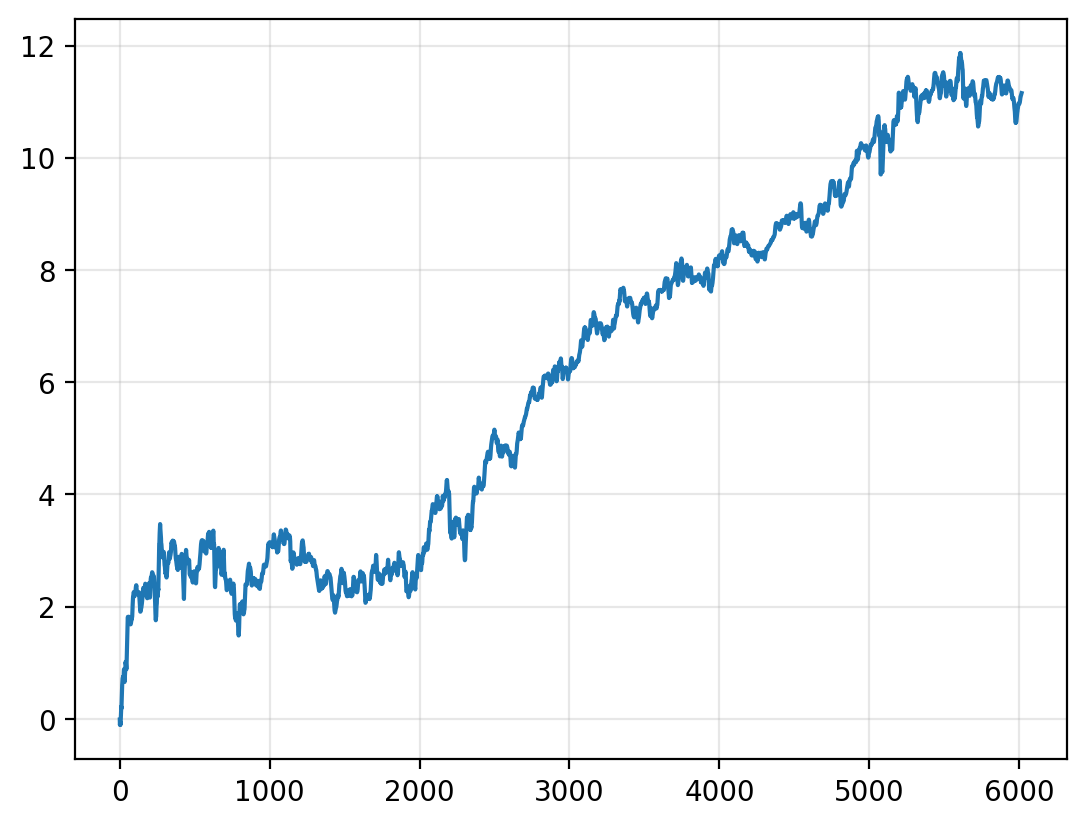

In [36]:
plt.plot(returns_bandit.cumsum())
plt.grid(alpha=0.3)

In [37]:
@partial(jax.vmap, in_axes=(None, 0, None))
@partial(jax.vmap, in_axes=(None, None, 0))
def returns_bandit(state, alpha, epsilon):
    _, returns_bandit = jax.lax.scan(partial(epsilon_ewm_step, epsilon=epsilon, alpha=alpha), state, returns)
    return returns_bandit.sum()

In [38]:
alpha_values = jnp.linspace(0.01, 1, 50)
epsilon_values = jnp.linspace(1e-7, 1, 50)
final_reward = returns_bandit(state, alpha_values, epsilon_values)

In [39]:
final_reward = pd.DataFrame(np.array(final_reward), index=alpha_values, columns=epsilon_values)

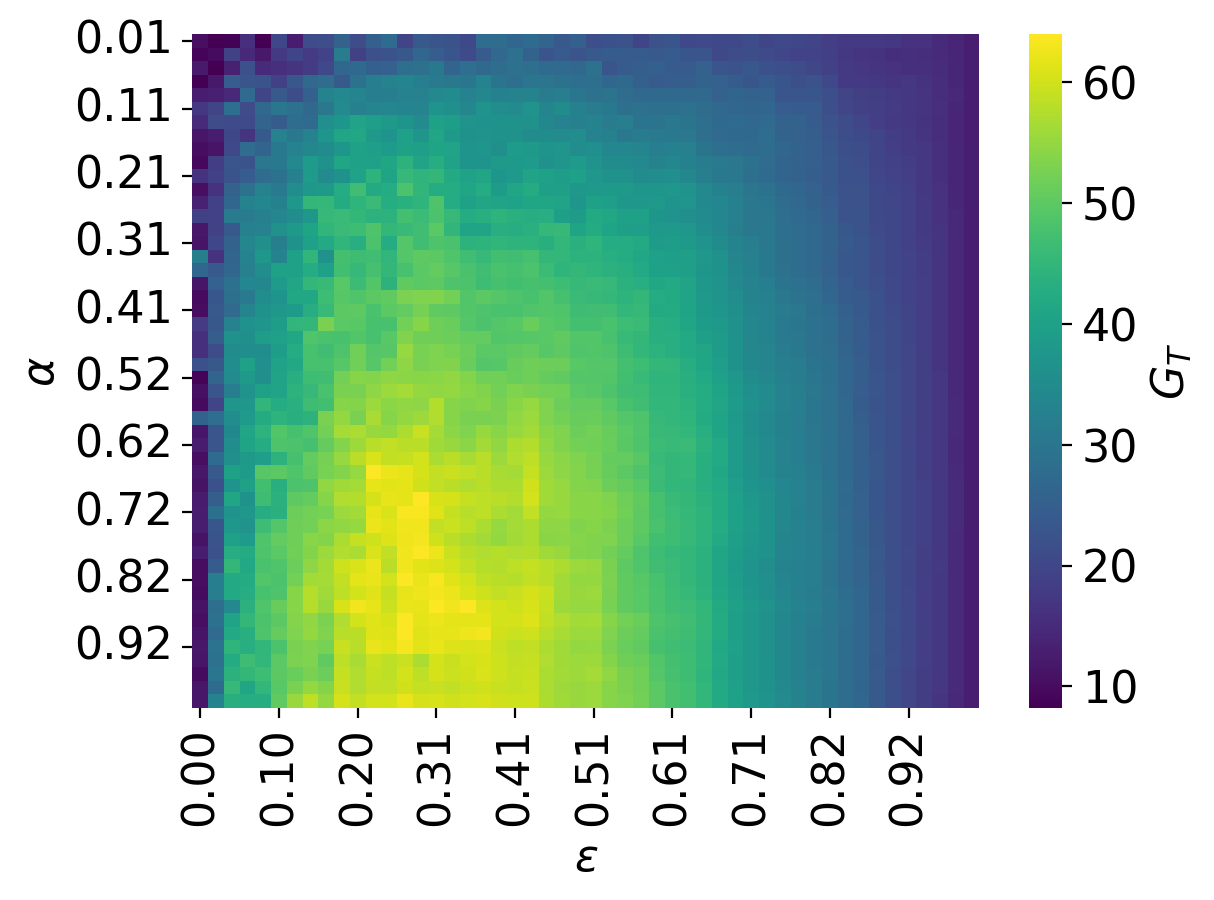

In [66]:
ax = sns.heatmap(
    final_reward,
    # annot=True,
    xticklabels=5,
    yticklabels=5,
    cmap="viridis",
    cbar_kws={"label": "$G_T$"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
plt.savefig("rl-bandits-epsilon-rewards-grid.png", dpi=300);